In [1]:
from __future__ import annotations
from typing import Callable, Dict, Tuple, List

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize, TwoSlopeNorm
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from xgboost import XGBClassifier
import os
import pickle
plt.rcParams["svg.fonttype"] = "none"

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler, QuantileTransformer, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, LSTM, BatchNormalization, Bidirectional, GlobalAveragePooling1D, MaxPooling1D, Flatten, Dense, Dropout, Input, Activation, LayerNormalization
from tensorflow.keras import regularizers

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-12-22 10:30:22.503622: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-22 10:30:31.348743: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Training framework for all models**

In [5]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
import numpy as np

def get_dense_builder(lr: float = 1e-4,
                      l2: float = 1e-2) -> Callable[[int, int], Sequential]:

    def _builder(n_features: int, n_classes: int) -> Sequential:
        model = Sequential([
            Input(shape=(n_features,)),

            Dense(128),
            BatchNormalization(),
            Activation('relu'),

            Dense(64),
            BatchNormalization(),
            Activation('relu'),

            Dense(n_classes, activation='softmax')
        ])

        opt = Adam(learning_rate=lr, weight_decay=l2)
        model.compile(optimizer=opt,
                      loss='categorical_crossentropy',
                      weighted_metrics=['accuracy', "AUC"])
        return model
    _builder.needs_onehot = True     
    return _builder
    

def get_logreg_builder(**kwargs):
    def _builder(_: int, __: int):
        return LogisticRegression(max_iter=10000,
                                  class_weight='balanced',
                                  n_jobs=-1,
                                  penalty='l2',
                                  **kwargs)
    _builder.needs_onehot = False
    return _builder

def plot_history(history, fold, rep):
    plt.plot(history.history["auc"], label="train")
    plt.plot(history.history["val_auc"], label="val")
    plt.title(f"Fold {fold} rep {rep+1}")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy")
    plt.legend(); plt.show()

    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title(f"Fold {fold} rep {rep+1}")
    plt.xlabel("Epochs"); plt.ylabel("Loss")
    plt.legend(); plt.show()     

def get_cnnlstm_builder(dropout: float = 0.3,
                        lr: float = 5e-5,
                        l2: float = 1.0) -> Callable[[Tuple[int, int], int], Sequential]:
    

    def _builder(input_shape: Tuple[int, int], n_classes: int) -> Sequential:
        length, n_feat = input_shape
        model = Sequential([
            Input(shape=(length, n_feat)),

            Conv1D(filters=64, kernel_size=10, activation="relu", padding="same"),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=64, kernel_size=10, activation="relu", padding="same"),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=64, kernel_size=10, activation="relu", padding="same"),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=64, kernel_size=10, activation="relu", padding="same"),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=64, kernel_size=10, activation="relu", padding="same"),
            MaxPooling1D(pool_size=2),

            GlobalAveragePooling1D(),

            Dense(32, activation="relu"),
            Dropout(dropout),
            Dense(n_classes, activation="softmax")
        ])
        
        opt = Adam(learning_rate=lr)
        model.compile(optimizer=opt,
                      loss="categorical_crossentropy",
                      weighted_metrics=["accuracy", "AUC"])
        return model
    
    _builder.needs_onehot = True   
    return _builder

def get_sample_weights(y: np.ndarray) -> np.ndarray:
        y_int = np.argmax(y, axis=1) 
        class_counts = np.bincount(y_int)
        weights = {cls: sum(class_counts)/(len(class_counts) * cnt) 
                for cls, cnt in enumerate(class_counts)}
        sample_weight = np.array([weights[c] for c in y_int])
        return sample_weight

def _softmax(z):
    z_exp = np.exp(z - z.max(axis=1, keepdims=True))
    return z_exp / z_exp.sum(axis=1, keepdims=True)

from sklearn.decomposition import PCA


MODEL_REGISTRY: Dict[str, Callable] = {
    "dense":   get_dense_builder(),
    "cnnlstm": get_cnnlstm_builder(),
    "logreg":  get_logreg_builder(),
}

def run_cv(model_key: str,
           X: np.ndarray,
           y: np.ndarray,
           class_names: List[str],
           n_splits: int = 3,
           dense_reps: int = 10,
           random_state: int = 0,
           verbose: bool = True,
           scaler: str = "minmax") -> Tuple[List[dict], List[str]]:
    
    if model_key != "cnnlstm":
        if scaler == "standard":
            X = StandardScaler().fit_transform(X)
        elif scaler == "minmax":
            X = MinMaxScaler().fit_transform(X)
        elif scaler == "robust":
            X = RobustScaler().fit_transform(X)
        elif scaler == "quantile":
            X = QuantileTransformer(output_distribution="normal").fit_transform(X)
        elif scaler == "maxabs":
            X = MaxAbsScaler().fit_transform(X)
        elif scaler is None:
            pass
        else:
            raise ValueError(
                f"Scaler '{scaler}' not supported. "
                "Use 'standard', 'minmax', 'robust', 'quantile', 'maxabs' or None."
            )

    if X.ndim == 3 and model_key != "cnnlstm":
        print(f"Detected 3‑D input X{X.shape}; using 'cnnlstm' model.")
        model_key = "cnnlstm"

    builder = MODEL_REGISTRY[model_key]
    onehot_needed = getattr(builder, "needs_onehot", False)

    y_cls  = np.argmax(y, axis=1)
    y_1hot = y

    skf = StratifiedKFold(n_splits=n_splits,
                          shuffle=True,
                          random_state=random_state)

    fold_histories = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_cls), 1):
        best_acc, best_model = -np.inf, None

        reps = dense_reps if ((model_key == "dense") or (model_key == "cnnlstm")) else 1
        for rep in range(reps):
            n_classes = (y_1hot.shape[1])

            in_desc = X.shape[1:] if model_key == "cnnlstm" else X.shape[1]
            model = builder(in_desc, n_classes)

            X_train, X_test = X[train_idx], X[test_idx]

            if onehot_needed:
                y_train, y_test = y_1hot[train_idx], y_1hot[test_idx]
            else:
                y_train, y_test = y_cls[train_idx], y_cls[test_idx]

            weights_train = get_sample_weights(y_train) if model_key in {"dense", "cnnlstm"} else None
            weights_test = get_sample_weights(y_test) if model_key in {"dense", "cnnlstm"} else None

            if model_key == "dense" or model_key == "cnnlstm":   
                early = EarlyStopping("val_loss", patience=15,
                                      restore_best_weights=True)
                history = model.fit(X_train, y_train,
                          validation_data=(X_test, y_test, weights_test),
                          epochs=10_000, verbose=1, batch_size=8,
                          callbacks=[early],
                          sample_weight=weights_train
                          )

                # plot_history(history, fold, rep)
                
                y_prob = model.predict(X_test, verbose=0)

            else:                                
                model.fit(X_train, y_train)
                if hasattr(model, "predict_proba"):
                    y_prob = model.predict_proba(X_test)
                else: 
                    scores = model.decision_function(X_test)
                    if scores.ndim == 1:     
                        scores = np.vstack([-scores, scores]).T
                    y_prob = _softmax(scores)

            y_pred = np.argmax(y_prob, axis=1)
            acc = balanced_accuracy_score(y_cls[test_idx], y_pred)   

            if n_classes == 2:
                auc_score = roc_auc_score(y_cls[test_idx], y_prob[:, 1])
            else:
                auc_score = roc_auc_score(y_cls[test_idx], y_prob,
                                          multi_class='ovr', average='macro')
            if verbose:
                print(f"  rep {rep+1}/{reps}: acc={acc:.3f}  auc={auc_score:.3f}")
                
            if acc > best_acc:
                best_acc = acc
                best_model = model
                best_prob  = y_prob
                best_pred  = y_pred

        n_classes = best_prob.shape[1]
        y_test_bin = label_binarize(y_cls[test_idx], classes=np.arange(n_classes))

        fpr = {}
        tpr = {}

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], best_prob[:, i])

        fpr = np.concatenate(list(fpr.values()))
        tpr = np.concatenate(list(tpr.values()))

        roc_auc = roc_auc_score(y_cls[test_idx], best_prob,
                                multi_class='ovr', average='macro')

        cm = confusion_matrix(y_cls[test_idx], best_pred)

        fold_histories.append(dict(
            model=best_model,
            acc=best_acc,
            cm=cm,
            fpr=fpr, tpr=tpr, auc=roc_auc,
            X_eval=X_test,
            y_eval=y_test
        ))

        if verbose:
            print(f"Fold {fold}: acc={best_acc:.3f}  auc={roc_auc:.3f}")

    if verbose:
        print(f"\n===  CV accuracy: {np.mean([h['acc'] for h in fold_histories]):.3f}  ===")
        print(f"===  CV AUC: {np.mean([h['auc'] for h in fold_histories]):.3f}  ===")

    return fold_histories, class_names

def plot_fold_metrics(fold_histories, class_names):
    for i, h in enumerate(fold_histories, 1):
        fpr, tpr, roc_auc = h["fpr"], h["tpr"], h["auc"]
        cm = h["cm"]

        if fpr is not None:  
            plt.figure()
            plt.plot(fpr, tpr, label=f'Fold {i} (AUC={roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], '--', color='gray')
            plt.xlabel("FPR"); plt.ylabel("TPR")
            plt.title(f"ROC – Fold {i}"); plt.legend(); plt.show()

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion – Fold {i}")
        plt.ylabel("Actual"); plt.xlabel("Predicted")
        plt.tight_layout(); plt.show()


def plot_agg_metrics(fold_histories, class_names, name=None):
    cms = np.stack([h["cm"] for h in fold_histories], axis=0)
    avg_cm = cms.sum(axis=0)

    class_support = avg_cm.sum(axis=1)           
    class_acc = np.diag(avg_cm) / class_support  
    weighted_acc = np.sum(class_acc * class_support) / np.sum(class_support)

    print(f"\n===  Mean CV weighted accuracy: {weighted_acc:.3f}  ===")

    plt.figure(figsize=(6, 5))
    avg_cm_perc = avg_cm.astype('float') / avg_cm.sum(axis=1)[:, np.newaxis] * 100

    colors = ["#F4F7F8", "#D03C75"]
    cmap = LinearSegmentedColormap.from_list("ebony_to_pink", colors)

    sns.heatmap(avg_cm_perc, annot=True, fmt='.1f', cmap="Purples",
                xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=80)
    plt.title("Average confusion matrix"); plt.ylabel("Actual"); plt.xlabel("Predicted")
    plt.tight_layout()

    plt.text(avg_cm.shape[1]-1.2, avg_cm.shape[0]+0.4, f'Weighted Acc: {weighted_acc:.3f}',
             fontsize=12, va='center')
    
    if name is not None:
        plt.savefig("/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/analysis/revision/results/" + name + "_confusion_matrix.svg", bbox_inches='tight')

    plt.show()

    if fold_histories[0]["fpr"] is not None:
        plt.figure()
        for i, h in enumerate(fold_histories, 1):
            plt.plot(h["fpr"], h["tpr"], label=f'Fold {i} (AUC={h["auc"]:.2f})')
        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.title("Combined ROC"); plt.legend(); plt.tight_layout()
        plt.show()

In [11]:
def class_balanced_weights_from_onehot(C):
    counts = C.sum(axis=0)                 
    inv = np.where(counts > 0, 1.0 / counts, 0.0)
    per_class = inv / C.shape[1]         
    w = (C * per_class).sum(axis=1)      
    w = w / w.sum()                      
    return w

def ig_all_classes(model, X, y, m=50):


    X = np.asarray(X, dtype=np.float32)

    B, F = X.shape
    baseline = np.zeros_like(X)
    
    X_tf = tf.convert_to_tensor(X, tf.float32)
    baseline_tf = tf.convert_to_tensor(baseline, tf.float32)
    delta_tf = X_tf - baseline_tf

    C = int(model.output_shape[-1])

    ig = np.zeros((m, B, F, C))
    alphas_tf = tf.linspace(0.0, 1.0, m)

    for i, a in enumerate(alphas_tf):
        xa = baseline_tf + a * delta_tf
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xa)
            probs = model(xa, training=False)
            probs = tf.math.log(probs)
            for k in range(C):
                gk = tape.gradient(probs[:, k], xa) 
                ig[i, :, :,k] = gk.numpy()
        del tape  

    delta = (X - baseline_tf)[..., np.newaxis]  
    ig = np.mean(ig, axis=0) * delta

    weight = class_balanced_weights_from_onehot(y)[..., np.newaxis, np.newaxis]  
    ig = np.sum(ig*weight, axis=0)
    
    return ig

def plot_cv_feature_weights_heatmap(
    fold_histories,
    feature_names,
    model_key,
    top_n: int = 20,
    class_names=None,
    use_absolute: bool = False,
    row_cluster: bool = True,
    col_cluster: bool = True,
):


    def _per_class_importance(model, X, y) -> np.ndarray:

        if model_key == "dense":
            imp = ig_all_classes(model, X, y, m=50).T
        elif model_key == "logreg":
            coef = model.coef_.T[None, :, :,] * X[:, :, None]
            coef = coef.mean(axis=0).T
            print("LogReg coef shape:", coef.shape)
            imp = coef
        else:
            raise ValueError(f"Unsupported model_key: {model_key}")
        return imp

    per_fold = [_per_class_importance(h["model"], h["X_eval"], h["y_eval"]) for h in fold_histories]

    print(f"Per-fold importance shapes: {[a.shape for a in per_fold]}")
    n_classes  = max(arr.shape[0] for arr in per_fold)
    
    imp_mean = np.mean(np.stack(per_fold, axis=0), axis=0)  
    print("Mean importance shape:", imp_mean.shape)
    if class_names is None or len(class_names) != n_classes:
        class_names = [f"Class {i}" for i in range(n_classes)]

    row_labels = []
    row_data = []

    for c in range(n_classes):
        idxs = np.argsort(imp_mean[c, :])[::-1][:top_n]
        for i in idxs:
            if f"{feature_names[i]}" in row_labels:
                continue
            else:
                row_labels.append(f"{feature_names[i]}")
                row_data.append(imp_mean[:, i])

    mat = np.vstack(row_data)

    custom_div = LinearSegmentedColormap.from_list(
        'custom_div', ['#00BFC4', '#DFDFDF', '#F8766D'], N=256
    )
    blues_cmap = sns.color_palette("Blues", as_cmap=True)

    if use_absolute:
        data = np.abs(mat)
        vmax = float(np.max(np.abs(data)))
        cmap = blues_cmap
        norm = None
        cbar_label = "Absolute weight"
    else:
        data = mat
        vmax = float(np.max(np.abs(data)))
        cmap = custom_div
        norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
        cbar_label = "Signed weight"

    df = pd.DataFrame(data, index=row_labels, columns=class_names)

    g = sns.clustermap(
        df,
        cmap=cmap,
        row_cluster=row_cluster,
        col_cluster=col_cluster,
        linewidths=0.3,
        linecolor="white",
        norm=norm,
        figsize=(6, 0.25*len(row_labels) + 2)
    )

    g.fig.suptitle(
        f"{model_key.upper()} – per-class TOP-{top_n} features (signed) → {len(row_labels)} rows",
        y=1.02, fontsize=14
    )

    cax = g.ax_cbar
    if cax is not None:
        cax.set_title(cbar_label, fontsize=10, pad=8)

    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=0, ha="center")
    plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=9)

    # plt.savefig(f"/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/analysis/revision/results/heatmap_{model_key}_{top_n}.svg", bbox_inches='tight')

    plt.show()
    return df, g

**Loading of encodings into feature and label matrix (X, y)**

In [3]:
def encode_localcider_dataset(df: pd.DataFrame,
                               feature_cols=None,
                               label_col="Label"):

    if feature_cols is None:
        feature_cols = df.columns[6:]
        
    X = df[feature_cols].to_numpy(dtype=np.float32)
    
    enc = OneHotEncoder(sparse_output=False, dtype=np.float32)
    y = enc.fit_transform(df[[label_col]])

    return X, y

def encode_sequence_padded(
    df: pd.DataFrame,
    seq_col: str = "Sequence",
    label_col: str = "Label"
                            ) -> tuple[np.ndarray, np.ndarray]:
    
    alphabet = "ACDEFGHIKLMNPQRSTVWY"
    unknown_token         = "X"  # slot for anything not in AA_ALPHABET

    if unknown_token and unknown_token not in alphabet:
        alphabet += unknown_token
    char_to_idx = {aa: i for i, aa in enumerate(alphabet)}
    depth = len(alphabet)

    seq_idx_lists = [
        [char_to_idx.get(ch, char_to_idx[unknown_token])
         for ch in seq.upper()]
        for seq in df[seq_col].astype(str)
    ]

    ragged_int = tf.ragged.constant(seq_idx_lists, ragged_rank=1, dtype=tf.int32)
    ragged_oh  = tf.one_hot(ragged_int, depth, dtype=tf.float32)
    X_tensor   = ragged_oh.to_tensor(default_value=0.0)    # shape=(B, max_len, depth)
    X = X_tensor.numpy()
    
    mask = (X == 0).all(axis=-1)
    X[mask] = -1.0
    
    enc = OneHotEncoder(sparse_output=False, dtype=np.float32)
    y = enc.fit_transform(df[[label_col]])

    return X, y

def prepare_esm2_encodings(esm_2_file_name: str):
    representations_45S_47S_df = pd.read_csv("/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/data/for_revision/curated_data_for_modeling/45S_47S_localcider_features_w_nardini_w_uniprot.tsv", sep="\t")
    representations_45S_47S = np.load(f'/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/data/for_revision/esm2_representations/representations_45S_47S_esm2_650M.npy')

    group_array = np.array(representations_45S_47S_df['Label'].tolist()).reshape(-1, 1)

    encoder = OneHotEncoder(sparse_output=False)
    group_onehot = encoder.fit_transform(group_array)
    group_onehot.shape

    y = group_onehot
    X = representations_45S_47S

    return X, y

In [12]:
representations_45S_47S_df = pd.read_csv("/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/data/for_revision/curated_data_for_modeling/45S_47S_localcider_features_w_nardini_w_uniprot.tsv", sep="\t")
representations_45S_47S_df = representations_45S_47S_df[~(representations_45S_47S_df[representations_45S_47S_df.columns[6:]].isna().any(axis=1))]
representations_45S_47S_df = representations_45S_47S_df.drop(columns=representations_45S_47S_df.columns[(representations_45S_47S_df == 0.0).all()])
feature_names_all = representations_45S_47S_df.columns[6:]
print("Final feature names:", len(feature_names_all), feature_names_all.tolist())

X_cider, y_cider = encode_localcider_dataset(representations_45S_47S_df, feature_names_all)
X_seqs, y_seqs = encode_sequence_padded(representations_45S_47S_df)
X_esm2, y_esm2 = prepare_esm2_encodings("representations_esm2_650M")

print(X_cider.shape, y_cider.shape)
print(X_seqs.shape, y_seqs.shape)   
print(X_esm2.shape, y_esm2.shape)

class_names = ["Nuclear Control", "45S", "47S"]

Final feature names: 3481 ['length', 'FCR', 'NCPR', 'isoelectric_point', 'molecular_weight', 'count_negative', 'count_positive', 'count_neutral', 'fraction_negative', 'fraction_positive', 'fraction_expanding', 'fraction_disorder_promoting', 'mean_net_charge', 'mean_hydropathy', 'uversky_hydropathy', 'PPII_propensity', 'delta', 'delta_max', 'frac_A', 'frac_C', 'frac_D', 'frac_E', 'frac_F', 'frac_G', 'frac_H', 'frac_I', 'frac_K', 'frac_L', 'frac_M', 'frac_N', 'frac_P', 'frac_Q', 'frac_R', 'frac_S', 'frac_T', 'frac_V', 'frac_W', 'frac_Y', 'zsc_POLAR_POLAR', 'zsc_POLAR_HYDROPHOBIC', 'zsc_POLAR_POSITIVE', 'zsc_POLAR_NEGATIVE', 'zsc_POLAR_AROMATIC', 'zsc_POLAR_ALANINE', 'zsc_POLAR_PROLINE', 'zsc_POLAR_GLYCINE', 'zsc_HYDROPHOBIC_HYDROPHOBIC', 'zsc_HYDROPHOBIC_POSITIVE', 'zsc_HYDROPHOBIC_NEGATIVE', 'zsc_HYDROPHOBIC_AROMATIC', 'zsc_HYDROPHOBIC_ALANINE', 'zsc_HYDROPHOBIC_PROLINE', 'zsc_HYDROPHOBIC_GLYCINE', 'zsc_POSITIVE_POSITIVE', 'zsc_POSITIVE_NEGATIVE', 'zsc_POSITIVE_AROMATIC', 'zsc_POSITIVE_

**Beam search for the most predictive feature amongst 320 manually encoded**

In [ ]:
def select_features_by_auc(
    X: np.ndarray,
    y: np.ndarray,
    class_names: list[str],
    feature_names: list[str] | None = None,
    *,
    model_key: str = "dense",
    n_splits: int = 3,
    dense_reps: int = 3,
    auc_threshold: float = 0.7,
    random_state: int = 0,
    verbose: bool = True
):
    """
    Evaluates each feature individually (one-pass) and returns the ones
    whose single-feature AUC exceeds auc_threshold.
    """

    n_feats = X.shape[1]
    if feature_names is None:
        feature_names = [f"f{i}" for i in range(n_feats)]

    passed = []
    aucs = []

    for i in range(n_feats):
        fh, _ = run_cv(
            model_key,
            X[:, [i]],          # evaluate single feature i
            y,
            class_names=class_names,
            n_splits=n_splits,
            dense_reps=(dense_reps if model_key == "dense" else 1),
            random_state=random_state,
            verbose=False
        )
        mean_auc = np.mean([h["auc"] for h in fh])
        aucs.append(mean_auc)

        if verbose:
            print(f"{feature_names[i]} → AUC={mean_auc:.4f}")

        if mean_auc >= auc_threshold:
            passed.append((feature_names[i], i, mean_auc))

    if verbose:
        print("\nFeatures above threshold:")
        for name, idx, auc in passed:
            print(f"  {name} (idx={idx}) → AUC={auc:.4f}")

    return passed, aucs

passed, aucs = select_features_by_auc(
    X_cider,
    y_cider,
    class_names=class_names,
    feature_names=feature_names_all,
    model_key="logreg",
    auc_threshold=0.50,
    n_splits=3,
    random_state=0
)

**Loading of final features encodings into feature and label matrix (X, y)**

In [8]:
feature_names = ['FCR', 'NCPR', 'isoelectric_point', 'molecular_weight', 'fraction_negative', 'fraction_positive', 'fraction_expanding', 'fraction_disorder_promoting', 'mean_net_charge', 'mean_hydropathy', 'uversky_hydropathy', 'PPII_propensity', 'frac_A', 'frac_C', 'frac_D', 'frac_F', 'frac_G', 'frac_H', 'frac_I', 'frac_K', 'frac_L', 'frac_N', 'frac_P', 'frac_Q', 'frac_T', 'frac_V', 'frac_W', 'frac_Y', 'zsc_POLAR_POLAR', 'zsc_POLAR_HYDROPHOBIC', 'zsc_POLAR_POSITIVE', 'zsc_POLAR_NEGATIVE', 'zsc_POLAR_ALANINE', 'zsc_HYDROPHOBIC_HYDROPHOBIC', 'zsc_HYDROPHOBIC_POSITIVE', 'zsc_HYDROPHOBIC_NEGATIVE', 'zsc_HYDROPHOBIC_AROMATIC', 'zsc_HYDROPHOBIC_ALANINE', 'zsc_HYDROPHOBIC_GLYCINE', 'zsc_POSITIVE_POSITIVE', 'zsc_POSITIVE_NEGATIVE', 'zsc_POSITIVE_AROMATIC', 'zsc_POSITIVE_PROLINE', 'zsc_NEGATIVE_ALANINE', 'zsc_NEGATIVE_PROLINE', 'zsc_NEGATIVE_GLYCINE', 'zsc_AROMATIC_AROMATIC', 'zsc_AROMATIC_ALANINE', 'zsc_AROMATIC_PROLINE', 'zsc_AROMATIC_GLYCINE', 'zsc_ALANINE_PROLINE', 'zsc_ALANINE_GLYCINE', "3'-5' exonuclease", 'A to I editase', 'AB hydrolase-', 'ABC transmembrane type-', 'ABC transmembrane type-1', 'ADD', 'ADF-H', 'AGC-kinase C-terminal', 'ARID', 'AWS', 'AXH', 'Agenet-like', 'Alpha-type protein kinase', 'ApaG', 'Arf-GAP', 'B30.2/SPRY', 'BACK', 'BAG', 'BAH', 'BAR', 'BPTI/Kunitz inhibitor', 'BRCT', 'BRO', 'BSD', 'BTB', "Beta/gamma crystallin 'Greek key'", 'Bin3-type SAM', 'Bromo', 'C', 'C2', 'C2 DOCK-type', 'C2 NT-type', 'CAP-Gly', 'CID', 'CIDE-N', 'CMP/dCMP-type deaminase', 'COMM', 'COS', 'CRAL-TRIO', 'CRC', 'CRIB', 'CS', 'CSD', 'CTLH', 'CUB', 'CUE', 'CVC', 'Calpain catalytic', 'Carrier', 'Chromo', 'Chromo 2; shadow subtype', 'Collagen-like', 'Cullin neddylation', 'Cyclin N-terminal', 'DAD', 'DAGKc', 'DCUN', 'DDE-', 'DDT', 'DED', 'DEP', 'DEUBAD', 'DH', 'DHHC', 'DIX', 'DMA', 'DMAP1-binding', 'DOCKER', 'DRBM', 'DUSP', 'Deacetylase sirtuin-type', 'Death', 'Disintegrin', 'Dynamin-type G', 'E', 'EF-hand', 'EF-hand 1; degenerate', 'EGF-like 4; calcium-binding', 'EGF-like 7; calcium-binding', 'EGF-like; calcium-binding', 'ELM', 'ENTH', 'ERCC', 'EXPERA', 'Exonuclease', 'F-BAR', 'F-box', 'FAD-binding FR-type', 'FCP1 homology', 'FERM', 'FF', 'FH', 'FHA', 'FHA-like', 'FZ', 'Fe2OG dioxygenase', 'Ferric oxidoreductase', 'Fibronectin type-III', 'Flavodoxin-like', 'Follistatin-like', 'G protein gamma', 'G-alpha', 'GBD/FH', 'GG-type lectin', 'GH', 'GIY-YIG', 'GRAM', 'GST C-terminal', 'GST N-terminal', 'Galectin', 'Glutaredoxin', 'GoLoco', 'Grh/CP2 DB', 'Guanylate cyclase', 'H', 'HECT', 'HIN-', 'HIT', 'HNF-p', 'HORMA', 'HRDC', 'HSR', 'HTH CENPB-type', 'HTH HARE-type', 'HTH myb-type', 'HTH psq-type', 'HhH', 'Histidine kinase', 'Histone H2A', 'Histone-fold', 'I-EGF', 'IBB', 'IGFBP N-terminal', 'IPT/TIG', 'IRS-type PTB', 'Importin N-terminal', 'J', 'JmjC', 'JmjN', 'KASH', 'KH; atypical', 'KID', 'KRAB', 'Kazal-like', 'Kinesin motor', 'Ku', 'LDL-receptor class A', 'LEM', 'LIM interaction domain (LID)', 'LITAF', 'LRRCT', 'LRRNT', 'LTD', 'Laminin G-like', 'Lon N-terminal', 'Lon proteolytic', 'LysM', 'MADS-box', 'MAGE', 'MARVEL', 'MATH', 'MBD', 'MEIS N-terminal', 'MH', 'MI', 'MIF4G', 'MIT', 'MPN', 'MRG', 'MSP', 'MYST-type HAT', 'Macro', 'MyTH', 'Myb-like', 'Myotubularin phosphatase', 'N-acetyltransferase', 'N-terminal Ras-GEF', 'NAC-A/B', 'NACHT', 'NET', 'NID', 'NR LBD', 'Nop', 'Nudix hydrolase', 'OCA', 'OCEL', 'OTU', 'Orange', 'PA', 'PAC', 'PAP-associated', 'PARP alpha-helical', 'PARP catalytic', 'PAS', 'PAZ', 'PB', 'PBC', 'PDEase', 'PET', 'PH', 'PI-PLC X-box', 'PI-PLC Y-box', 'PID', 'PINIT', 'PINc', 'PIPK', 'PLA2c', 'PLD phosphodiesterase', 'PNT', 'POLO box', 'POU-specific', 'POU-specific atypical', 'PPIase FKBP-type', 'PPIase cyclophilin-type', 'PRELI/MSF', 'PSI', 'PUA', 'PUB', 'PUM-HD', 'PWWP', 'PX', 'Peptidase M', 'Peptidase M12B', 'Peptidase S', 'Piwi', 'Post-SET', 'PpiC', 'Pre-SET', 'Protein kinase', 'Pseudo-CRIB', 'Pyrin', 'R3H', 'RBD', 'REKLES', 'REM-', 'REM-1', 'RGS', 'RHD', 'RNase H type-', 'RNase III', 'RRM', 'RUN', 'RWD', 'Rab-GAP TBC', 'Radical SAM core', 'RanBD', 'Rap-GAP', 'Ras-GEF', 'Ras-associating', 'Rho-GAP', 'Rhodanese', 'Runt', 'S1 motif', 'SAM', 'SAM-dependent MTase C5-type', 'SAM-dependent MTase PRMT-type', 'SAM-dependent MTase TRM10-type', 'SAND', 'SARAH', 'SCA', 'SCAN box', 'SCD', 'SEC', 'SEFIR', 'SEP', 'SERTA', 'SET', 'SGS', 'SH2', 'SOCS box', 'SPAZ', 'SPOC', 'SRCR', 'SSD', 'START', 'STI1', 'SUN', 'SUZ-C', 'SWIB/MDM', 'Single-minded C-terminal', 'SoHo', 'Sox C-terminal', 'TAFH', 'TB', 'TFIIS N-terminal', 'TFIIS central', 'TLDc', 'TTL', 'Thioredoxin', 'Thyroglobulin type-', 'Topo IB-type catalytic', 'Tudor', 'Tudor-knot', 'Tyrosine-protein phosphatase', 'UBA', 'UBA-like', 'UBC core', 'UBX', 'UCH catalytic', 'ULD', 'USP', 'Ubiquitin-like', 'UmuC', 'VPS', 'VWFA', 'VWFC', 'W', 'WAC', 'WGR', 'WW', 'WWE', 'YDG', 'YEATS', 'Yippee', 'ZP', 'ZU', 'bHLH', 'bMERB', 'bZIP', 'cDENN', 'dDENN', 'sHSP', 'tRNA-binding', 'uDENN', '10 X repeats starting with a Trp in each unit', '3 X 3 AA repeats of N-P-F', '3 X 9 AA approximate tandem repeats', '3 X approximate repeats', '5 X 2 AA repeats of F-G', 'A', 'AF-', 'AIS', 'Actin-binding', 'Activation loop', 'Activation segment', 'Adenine-nucleotide binding in RNA target', 'Alpha', 'Arg/Ser-rich domain', 'Ariadne domain', 'Autoinhibitory domain', 'Autoinhibitory helix', 'B', 'BC-box', 'Basic motif', 'Basic motif; degenerate', 'Beta', 'Beta domain', "Beta(2)beta(3) 'finger-like' loop", 'C.1', 'C-LIP', 'C-domain', 'C-terminal domain (CTD)', 'C-terminal domain; mediates TORC1 regulation', 'CABIT', 'CRY binding domain', 'CSNK1E binding domain', 'CTNNB1-binding', 'Calcineurin-binding', 'Calmodulin-binding', 'Catalytic', 'CcN domain', 'Class A specific domain', 'Clathrin-binding', 'Connecting peptide', 'CuBD subdomain', 'Cyclin A/CDK2 binding', 'Cyclin-like', 'Cys-loop', 'D domain', 'DACHbox-C', 'DACHbox-N', 'DNA-binding', 'DVD domain', 'Dimerization', 'Dimerization (DIM)', 'Disordered', 'Domain A', 'Domain B', 'Domain III', 'Domain IV', 'Flexible hinge', 'Flexible linker', 'G.1', 'G2 motif', 'G5 motif', 'GFLD subdomain', 'GP domain', 'GRR', 'Globular', 'Globular head', 'Guanine-nucleotide binding in RNA target', 'H-S-H (helix-span-helix), dimerization', 'Helix-loop-helix motif', 'Heparin-binding', 'His cluster', 'His-loop', 'Histidine-rich domain (HRD)', 'Histone H3K4me3 and H3R8me2a binding', 'Histone H3K9me binding', 'Histone deacetylase', 'Histone-binding', 'Homodimerization', 'Hydrophobic repeat HR-A/B', 'Hydrophobic repeat HR-C', 'I-domain', 'Important for homodimerization', 'Interaction with 5-mCpG DNA', 'Interaction with AR', 'Interaction with ARHGEF', 'Interaction with ATF', 'Interaction with ATRIP', 'Interaction with AXIN', 'Interaction with BCL', 'Interaction with BMI', 'Interaction with BRCA', 'Interaction with CCAR', 'Interaction with CD2AP', 'Interaction with CDK', 'Interaction with CDKN1A', 'Interaction with CREBBP', 'Interaction with CRY', 'Interaction with CTBP', 'Interaction with CTNND', 'Interaction with DAB', 'Interaction with DDX', 'Interaction with DNA', 'Interaction with DNMT3A', 'Interaction with E4F', 'Interaction with EED', 'Interaction with ESR', 'Interaction with Elongin BC complex', 'Interaction with GATA', 'Interaction with HCFC', 'Interaction with HDAC', 'Interaction with HGS', 'Interaction with HIPK', 'Interaction with IFI', 'Interaction with IST', 'Interaction with KAT', 'Interaction with KATNB', 'Interaction with KDM5B', 'Interaction with LMNA', 'Interaction with LMO', 'Interaction with MAGI', 'Interaction with MAP3K', 'Interaction with MAPK', 'Interaction with MCM', 'Interaction with MEF2A', 'Interaction with METTL', 'Interaction with MYC', 'Interaction with NAA', 'Interaction with NCOR', 'Interaction with NPM', 'Interaction with NR1D', 'Interaction with NSMCE', 'Interaction with OGT', 'Interaction with PAK', 'Interaction with PALB', 'Interaction with PARD3 and CDC', 'Interaction with PARP', 'Interaction with PCNA', 'Interaction with PLCG', 'Interaction with PLK', 'Interaction with POLR2A', 'Interaction with PPARG', 'Interaction with PPP1R15A', 'Interaction with PTEN', 'Interaction with RAC', 'Interaction with RAD', 'Interaction with RAD51C', 'Interaction with RB', 'Interaction with RBBP', 'Interaction with RNA', 'Interaction with ROCK', 'Interaction with SF3B', 'Interaction with SF3B1 and SF3B', 'Interaction with SIN3A', 'Interaction with SIN3A and SIN3B', 'Interaction with SIRT', 'Interaction with SNRNP', 'Interaction with SOX', 'Interaction with SPAST', 'Interaction with SREBF', 'Interaction with STAT', 'Interaction with SUMO', 'Interaction with SUPT6H', 'Interaction with SUZ', 'Interaction with TACC', 'Interaction with TDRD', 'Interaction with TGFB1I', 'Interaction with THOC', 'Interaction with TIMELESS', 'Interaction with TNPO', 'Interaction with TOR1A', 'Interaction with TP', 'Interaction with TTN', 'Interaction with UBE2I', 'Interaction with USP', 'Interaction with VCL', 'Interaction with VPS4A, MITD1 and STAMBP', 'Interaction with VPS4B', 'Interaction with VTA', 'Interaction with WDR', 'Interaction with WWP', 'Interaction with YWHAB', 'Interaction with ZBTB', 'Interaction with ZNF', 'Interaction with beta-catenin', 'Interaction with calmodulin', 'Interaction with dsRNA', 'Interaction with guide RNA', 'Interaction with histone H', 'Interaction with p53/TP', 'Interaction with target DNA', 'Interaction with the C-terminus of SPBC', 'Interaction with the Mediator complex', 'Interaction with the N-terminus of SPBC', 'Interaction with the PRC2/EED-EZH2 complex', 'Interaction with ubiquitin', 'Intramolecular interaction with C-terminus', 'Intramolecular interaction with N-terminus', 'LID', 'LIM-binding domain (LID)', 'LMNA-binding', 'Leucine-zipper', 'Lysyl-oxidase like', 'Mediates homooligomerization', 'Mediates interaction with CDK5RAP', 'Mediates interaction with DDRGK', 'Mediates interaction with DNTTIP', 'Mediates interaction with RNF', 'Mediates interaction with RPA', 'Mediates interaction with TRIP', 'Mediates nuclear export', 'Mediates transcriptional activation', 'Membrane-binding amphipathic helix', 'Microtubule-binding', 'Mn', 'Modulating', 'Monooxygenase domain', 'N-LIP', 'N-domain', 'N-terminal', 'N-terminal domain', 'N-terminal domain; may mediate the alkylhydroperoxide reductase activity', 'NCD', 'NEMO-binding', 'NLS binding site (major)', 'NLS binding site (minor)', 'NMP', 'NTAD', 'Necessary and sufficient for the association with mRNA decay enzymes and mRNA decay activation', 'Necessary for RNA-binding', 'Necessary for interaction with USP', 'Necessary for mRNA decay activation', 'Necessary for nuclear localization', 'Necessary for transactivation activity', 'Necessary for transcriptional repression', 'Negative regulatory domain', 'Non-specific-nucleotide binding in RNA target', 'Nuclear localization', 'Nuclear localization signal', 'Nuclear localization signal (NLS)', 'Nuclease domain', 'Nucleotide-binding domain (NBD)', 'ODD', 'Oligomerization', 'P-domain', 'PAI subdomain', 'PBC-A', 'PBC-B', 'PBR', 'PEST', 'Pocket; binds T and E1A', 'Positively charged region required for RNA-binding', 'Protease', 'Q domain', 'RED subdomain', 'RNA binding', 'RNA-binding RGG-box', 'RS', 'Ran-GTP binding', 'RecA-like domain', 'Region II', 'Regulatory domain', 'Regulatory loop', 'Repeat-rich region', 'Repressor domain', 'Required and sufficient for interaction with KDM1A', 'Required for ATPase activity', 'Required for DNA-binding', 'Required for dimerization', 'Required for homodimerization', 'Required for insertion into the membrane', 'Required for interaction with FOXO', 'Required for interaction with GDF', 'Required for interaction with INCENP', 'Required for interaction with MAPK', 'Required for interaction with PALS', 'Required for interaction with PIP5K1A', 'Required for interaction with histone H', 'Required for localization to nuclear speckles', 'Required for macropage invasion', 'Required for maintaining the overall integrity of the AHR:ARNT heterodimer and its transcriptional activity', 'Required for membrane localization', 'Required for nuclear export', 'Required for nuclear import', 'Required for nuclear localization', 'Required for phosphorylation by CSNK1E and cytoplasmic localization', 'Required for repressor activity', 'Required for self-association', 'Required for the homodimerization of the C9orf72-SMCR8 complex', 'Required for transcriptional activation', 'Required for transcriptional repression', 'Retinoblastoma protein binding', 'Ripply homology domain', 'SAH', 'SBD', 'SNAG domain', 'SP domain', 'SUMO interaction motifs (SIM); required for nuclear localization and kinase activity', 'SUMO1-binding', 'Self-association', 'Small GTPase-like', 'Spacer', 'Speedy/Ringo box; Required for CDK-binding', 'Strong transcription activation domain', 'Substrate', 'Substrate binding', 'Substrate-binding domain (SBD)', 'Sufficient for interaction with MAD2L', 'Sufficient for interaction with SYNE1 and SYNE', 'Sufficient for nucleolar localization', 'Sufficient for strong transactivation activity', 'Sufficient for transactivation activity', 'TRAF-binding', 'TRIAD supradomain', 'Thioredoxin fold', 'Transactivation', 'Transactivation AF-1; required for ligand-independent transactivation function', 'Transactivation AF-2; required for ligand-dependent transactivation function; mediates interaction with CCAR', 'Transactivation domain', 'Transactivation domain (TAC)', 'Transactivation domain (TAM)', 'Transactivation domain 1 (TAD1)', 'Transactivation domain A (TAD-A)', 'Transcription repressor', 'Transcriptional activation', 'Transcriptional activation (acidic)', 'Transcriptional activation domain', 'Transcriptional repression and interaction with NCOR1 and SIN3A', 'Tudor-like', 'Tudor-like domain', 'UBA-like.1', 'Ubiquitin binding', 'Ubiquitin-binding domain (UBD)', 'Uracil-nucleotide binding in RNA target', 'Variable-loop', 'p38 MAPK-binding site', 'Basic residues', 'Polar residues']

X_cider, y_cider = encode_localcider_dataset(representations_45S_47S_df, feature_names)
print(X_cider.shape, y_cider.shape)


**Final training for logistic regression model on selected features**


===  Mean CV weighted accuracy: 0.633  ===


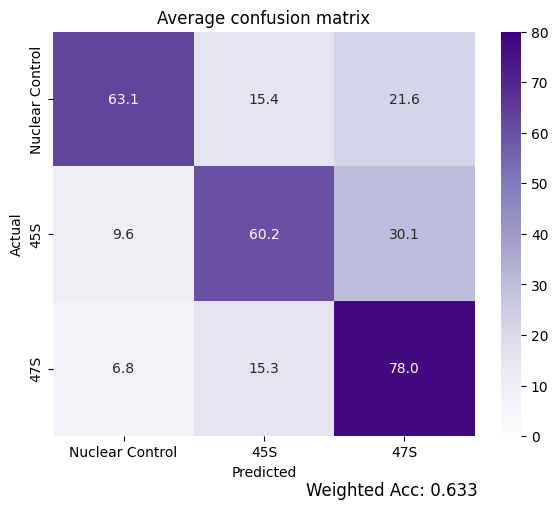

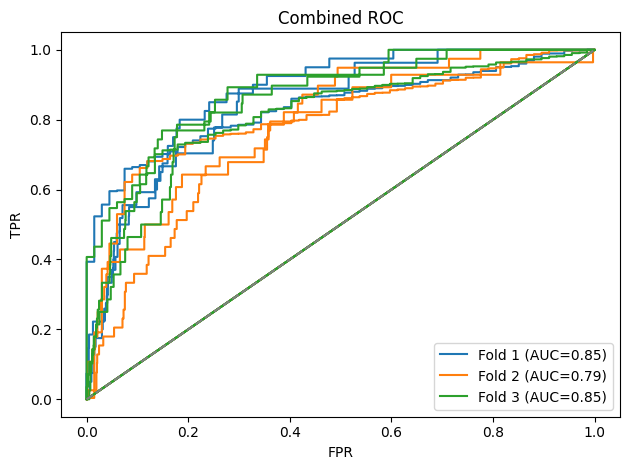

Per-fold importance shapes: [(3, 713), (3, 713), (3, 713)]
Mean importance shape: (3, 713)


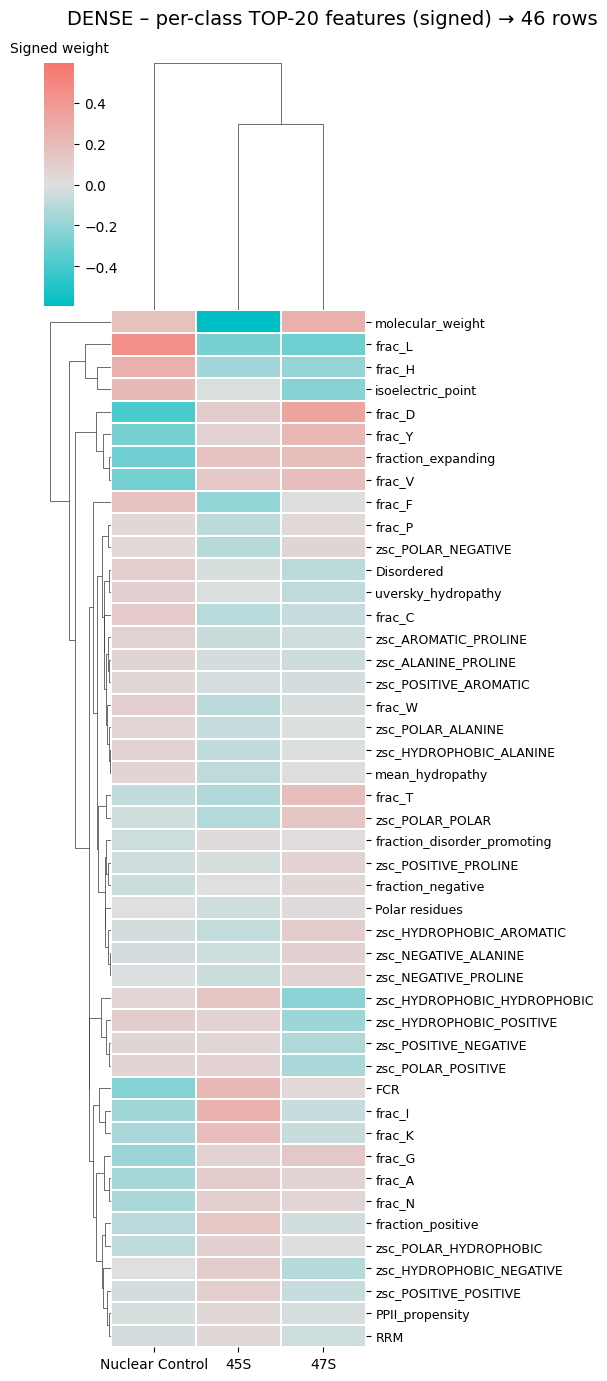

Per-fold importance shapes: [(3, 713), (3, 713), (3, 713)]
Mean importance shape: (3, 713)


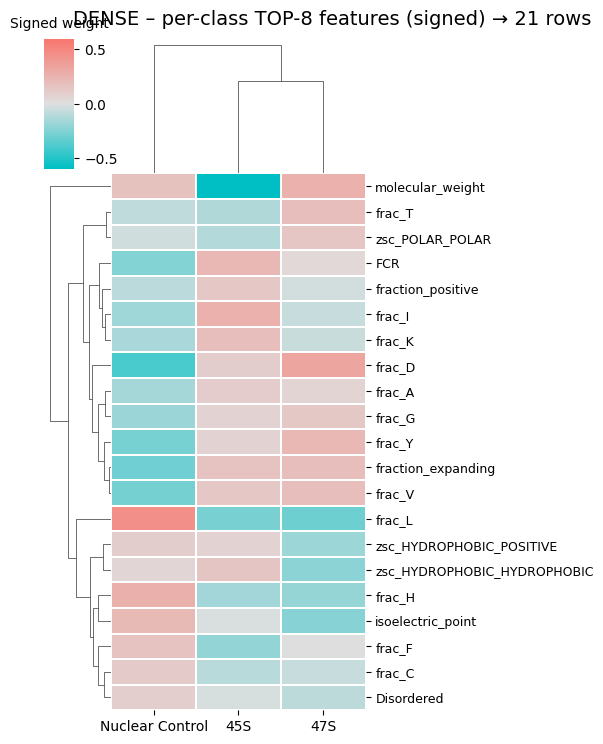

(                             Nuclear Control       45S       47S
 frac_L                              0.452601 -0.272970 -0.298021
 frac_H                              0.266371 -0.159699 -0.195048
 isoelectric_point                   0.211553 -0.015669 -0.236345
 molecular_weight                    0.166489 -0.595973  0.258589
 frac_F                              0.155927 -0.201059  0.007222
 frac_C                              0.116599 -0.100881 -0.062530
 zsc_HYDROPHOBIC_POSITIVE            0.099074  0.070981 -0.176389
 Disordered                          0.097610 -0.022411 -0.090747
 frac_I                             -0.168085  0.257985 -0.065170
 FCR                                -0.243693  0.226610  0.040270
 frac_K                             -0.143598  0.187469 -0.056501
 fraction_expanding                 -0.297475  0.159779  0.181675
 zsc_HYDROPHOBIC_HYDROPHOBIC         0.054865  0.146967 -0.222808
 frac_V                             -0.283881  0.133965  0.183769
 fraction_

In [12]:
model_key = "dense"

fold_hist_cider, cls_cider = run_cv(model_key, X_cider, y_cider, class_names, verbose=True, random_state=0, n_splits=3, scaler="minmax", dense_reps=10)
    
plot_agg_metrics(fold_hist_cider, class_names, name="cider_dense")

plot_cv_feature_weights_heatmap(fold_hist_cider, feature_names, model_key=model_key, top_n=20, use_absolute=False, class_names=class_names, row_cluster = True, col_cluster = True)
plot_cv_feature_weights_heatmap(fold_hist_cider, feature_names, model_key=model_key, top_n=8, use_absolute=False, class_names=class_names, row_cluster = True, col_cluster = True)

with open("/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/analysis/revision/results/fold_hist_cider_with_batchnorm.pkl", "wb") as f:
    pickle.dump(fold_hist_cider, f, protocol=pickle.HIGHEST_PROTOCOL)


**Final training for esm2 representation model**


===  Mean CV weighted accuracy: 0.677  ===


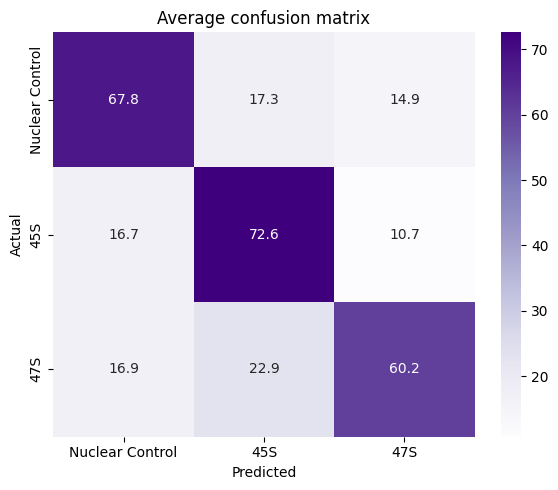

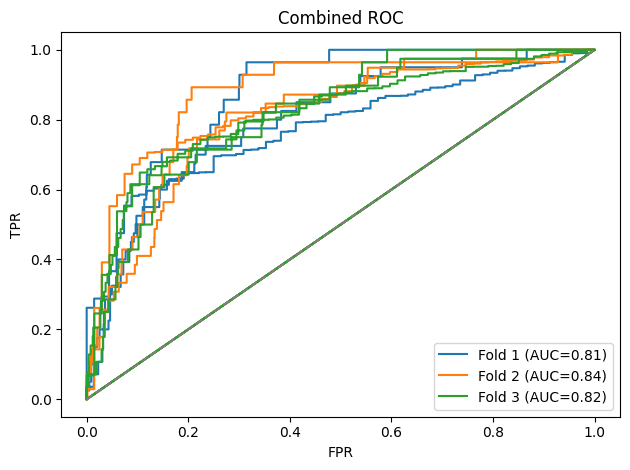

In [9]:
model_key = "dense"

fold_hist_esm2_15, cls_esm2_15 = run_cv(model_key, X_esm2, y_esm2, class_names, verbose=True, random_state=0, dense_reps=10, n_splits=3, scaler=None)

plot_agg_metrics(fold_hist_esm2_15, class_names)

with open("/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/analysis/revision/results/fold_hist_esm2_15.pkl", "wb") as f:
    pickle.dump(fold_hist_esm2_15, f, protocol=pickle.HIGHEST_PROTOCOL)

**Final training for amino acid sequence based model**


===  Mean CV weighted accuracy: 0.370  ===


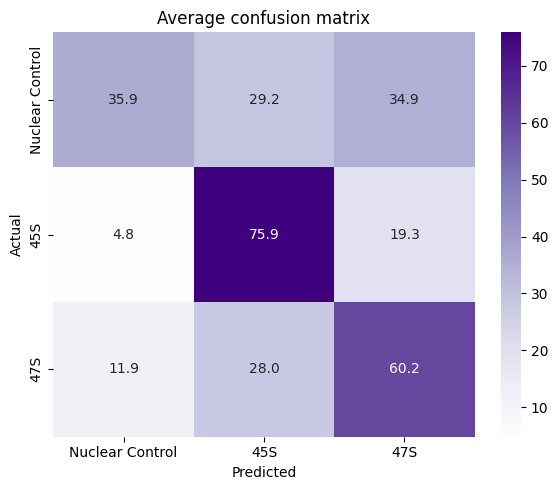

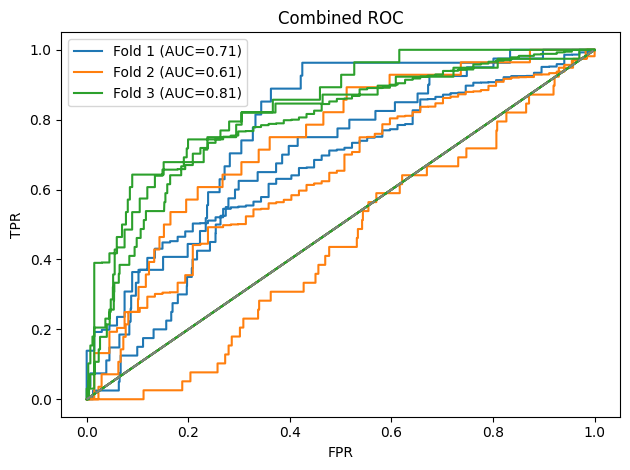

In [8]:
model_key = "cnnlstm"
class_names = ["Nuclear Control", "45S", "47S"]

fold_hist_seqs, cls_seqs = run_cv(model_key, X_seqs, y_seqs, class_names, verbose=True, random_state=0, dense_reps=10)
    
plot_agg_metrics(fold_hist_seqs, class_names)

with open("/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/analysis/revision/results/fold_hist_seqs.pkl", "wb") as f:
    pickle.dump(fold_hist_seqs, f, protocol=pickle.HIGHEST_PROTOCOL)


**Final performance analysis**

In [7]:
with open("/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/analysis/revision/results/fold_hist_cider.pkl", "rb") as f:
    fold_hist_cider = pickle.load(f)

with open("/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/analysis/revision/results/fold_hist_esm2_15.pkl", "rb") as f:
    fold_hist_esm2_15 = pickle.load(f)

with open("/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/analysis/revision/results/fold_hist_seqs.pkl", "rb") as f:
    fold_hist_seqs = pickle.load(f)

class_names = ["Nuclear Control", "45S", "47S"]

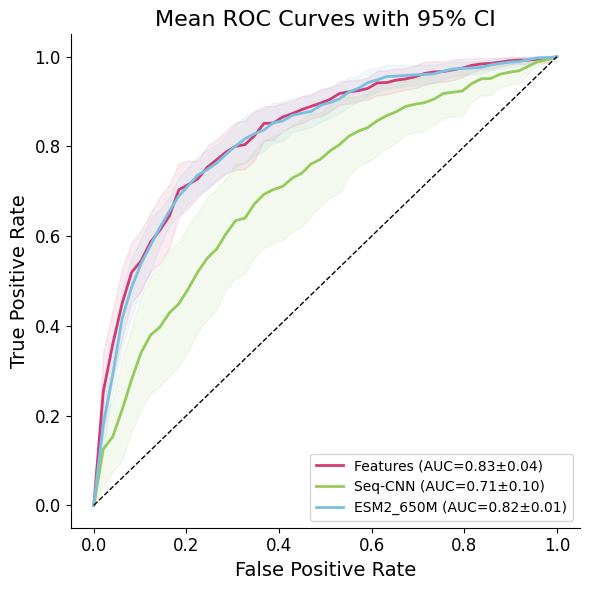

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc


def split_concatenated_roc(fpr, tpr):
    """
    Split concatenated multi-class ROC into separate monotonic segments.
    A new curve starts whenever FPR decreases.
    """
    fpr_groups = []
    tpr_groups = []

    cur_fpr = [fpr[0]]
    cur_tpr = [tpr[0]]

    for i in range(1, len(fpr)):
        if fpr[i] >= fpr[i - 1]:
            # still same class-ROC
            cur_fpr.append(fpr[i])
            cur_tpr.append(tpr[i])
        else:
            # FPR dropped -> new class-ROC starts
            fpr_groups.append(np.array(cur_fpr))
            tpr_groups.append(np.array(cur_tpr))
            cur_fpr = [fpr[i]]
            cur_tpr = [tpr[i]]

    # last segment
    fpr_groups.append(np.array(cur_fpr))
    tpr_groups.append(np.array(cur_tpr))

    return fpr_groups, tpr_groups


def plot_multi_cv_roc(fold_groups,
                      labels=None,
                      n_points=100,
                      ci_z=1.96,
                      figsize=(6, 6)):

    n_models = len(fold_groups)
    if labels is None:
        labels = [f"Model {i+1}" for i in range(n_models)]
    if len(labels) != n_models:
        raise ValueError("`labels` must match number of fold_groups")

    mean_fpr = np.linspace(0, 1, n_points)
    plt.figure(figsize=figsize)

    hex_color_dict = {
        "Features":   "#D03C75",
        "Seq-CNN":    "#93CC5C",
        "ESM2_650M":  "#79C1E1",
        "ESM2_3B":    "#F9AA64",
        "ESM2_15B":   "#F04020",
    }

    for group, label in zip(fold_groups, labels):
        tprs = []   # all interpolated tprs across folds × classes
        aucs = []   # auc for each of those curves

        for h in group:
            fpr_concat = np.array(h["fpr"])
            tpr_concat = np.array(h["tpr"])
            auc   = h["auc"] 

            # De-concatenate into per-class ROC curves
            fpr_splits, tpr_splits = split_concatenated_roc(fpr_concat, tpr_concat)

            for fpr_c, tpr_c in zip(fpr_splits, tpr_splits):
                # AUC for this class-curve
                # auc_score = auc(fpr_c, tpr_c)

                # interpolate this curve to common mean_fpr grid
                interp_tpr = np.interp(mean_fpr, fpr_c, tpr_c)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)

            aucs.append(auc)    

        # Now we have one tpr curve per (fold × class)
        tprs = np.vstack(tprs)       # shape: (n_curves, n_points)
        aucs = np.array(aucs)        # length: n_curves, e.g. 9

        mean_tpr = tprs.mean(axis=0)
        sem_tpr  = tprs.std(axis=0, ddof=1) / np.sqrt(tprs.shape[0])

        lower = np.clip(mean_tpr - ci_z * sem_tpr, 0, 1)
        upper = np.clip(mean_tpr + ci_z * sem_tpr, 0, 1)

        mean_auc = aucs.mean()
        std_auc  = aucs.std(ddof=1)

        color = hex_color_dict.get(label, "#000000")

        plt.plot(mean_fpr, mean_tpr,
                 lw=2.0,
                 color=color,
                 label=f"{label} (AUC={mean_auc:.2f}±{std_auc:.2f})")

        plt.fill_between(mean_fpr, lower, upper, alpha=0.1, color=color)

    plt.plot([0, 1], [0, 1], "--", color="black", lw=1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("Mean ROC Curves with 95% CI", fontsize=16)
    plt.legend(loc="lower right")
    plt.tight_layout()
    sns.despine()
    plt.savefig("/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/analysis/revision/results/roc_comparison.svg")
    plt.show()

plot_multi_cv_roc(
    [fold_hist_cider, fold_hist_seqs, fold_hist_esm2_15],
    labels=["Features", "Seq-CNN", "ESM2_650M"],
    n_points=50
)